## 220612 Our set of models, predicting and visualising each:

In [66]:
from lwb_smr.CustomDataLoader import CustomDataLoader
from lwb_smr.data import LoadDataSets
import os
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw


In [2]:
MODEL_NAMES = {
    'first_VGG16_full_bce': '220610_checkpoint_.h5',
    'latest_VVG16_bce': '220610_full_model_vgg16_10e_20e_more.h5',
    'latest_VGG16_dice': '220611_v7_UNET_VGG16_Dice_input_shape_224x224x3.h5',
    
}
RAW_DATA_PATH = '../../../raw_data/'
GCP_MODELS_PATH = 'lwb-solar-my-roof/models/'
PATH_HERE = 'lwb_smr/notebooks/day5'

# CHANGE THIS KEY TO LOAD THE MODEL YOU WANT

In [3]:
this_model = MODEL_NAMES['latest_VGG16_dice']
this_model

'220611_v7_UNET_VGG16_Dice_input_shape_224x224x3.h5'

In [4]:
model_load_string = f'{RAW_DATA_PATH}models/{this_model}'
path = Path(model_load_string)
assert path.is_file()

In [5]:
model_load_string

'../../../raw_data/models/220611_v7_UNET_VGG16_Dice_input_shape_224x224x3.h5'

In [6]:
print('copy THESE 2 LINES to push the model: '+ this_model + ' to the gcp bucket')
print('')
print(f'cd {PATH_HERE}')
print(f'gsutil cp {model_load_string} gs://{GCP_MODELS_PATH}{this_model}')

copy THESE 2 LINES to push the model: 220611_v7_UNET_VGG16_Dice_input_shape_224x224x3.h5 to the gcp bucket

cd lwb_smr/notebooks/day5
gsutil cp ../../../raw_data/models/220611_v7_UNET_VGG16_Dice_input_shape_224x224x3.h5 gs://lwb-solar-my-roof/models/220611_v7_UNET_VGG16_Dice_input_shape_224x224x3.h5


# LOAD THE MODEL SPECIFIED ABOVE:

In [7]:
model_load_string

'../../../raw_data/models/220611_v7_UNET_VGG16_Dice_input_shape_224x224x3.h5'

In [8]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

In [9]:
from tensorflow.keras.models import Model, Sequential

custom_objects_dict = {
                'dice_loss': dice_loss
}
loaded_model = tf.keras.models.load_model(model_load_string, custom_objects=custom_objects_dict)


2022-06-12 09:33:16.859389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 09:33:16.869572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 09:33:16.870251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 09:33:16.871437: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
# Check its architecture
loaded_model.summary()

Model: "first_VGG16_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                  

# PREDICT TOO

In [108]:
def plot_comparison(X_true, y_true, y_pred, a=0, b=1, c=2):
    """
    Function: Plots a 3x3 grid comparing test_image, mask_image, predicted_mask
    Inputs: X_true - [NumPy array] - RGB Image
            y_true - [NumPy array] - Mask of image to predict
            y_pred - [NumPy array] - predicted mask 
            a, b, c - [integer] - index of images to select from arrays 
    """
    
    f, axs = plt.subplots(3, 3, figsize=(12, 12))
    titles = ['Test Image', 'Test Label', 'Prediction Label',
             'Test Image', 'Test Label', 'Prediction Label',
             'Test Image', 'Test Label', 'Prediction Label'
             ]


    ax1, ax2, ax3 = axs[0,0], axs[0,1], axs[0,2]
    ax4, ax5, ax6 = axs[1,0], axs[1,1], axs[1,2]
    ax7, ax8, ax9 = axs[2,0], axs[2,1], axs[2,2]
    # idx = random.sample(range(0, X_test[:,:,:,:].shape[0]), 3)

    ax1.imshow(X_true) # [a,:,:,:])
    ax1.set_title('Test Image')
    ax2.imshow(y_true, cmap='gray') # [a,:,:,0])
    ax2.set_title('True Mask')
    ax3.imshow(y_pred, cmap='gray') # [a,:,:,0])
    ax3.set_title('Predicted Mask')

    ax4.imshow(X_true[b,:,:,:])
    ax5.imshow(y_true[b,:,:,0])
    ax6.imshow(y_pred[b,:,:,0])

    ax7.imshow(X_true[c,:,:,:])
    ax8.imshow(y_true[c,:,:,0])
    ax9.imshow(y_pred[c,:,:,0])

### LOAD ONE DATA POINT FOR PREDICTION

In [117]:
start_point = 400
no_points = 1
end_point = start_point+no_points
data_dict = LoadDataSets(RAW_DATA_PATH + "image_datasets_csv/train_dataset.csv",RAW_DATA_PATH + "image_datasets_csv/validation_dataset.csv").load_datasets()
predict_data = CustomDataLoader(data_dict['train_x'][start_point:end_point],RAW_DATA_PATH + "train_RGB_tiles_jpeg/",
                                data_dict['train_y'][start_point:end_point],RAW_DATA_PATH + "train_mask_tiles_jpeg/",
                                (250,250),16)

Datasets match, proceed


In [118]:
predict_data.__dict__

{'x': ['austin32_x14_y07.jpeg'],
 'y': ['austin32_mask_x14_y07.jpeg'],
 'x_path': '../../../raw_data/train_RGB_tiles_jpeg/',
 'y_path': '../../../raw_data/train_mask_tiles_jpeg/',
 'input_image_size': (250, 250),
 'batch_size': 16}

In [119]:
X_true_path = ['../../../raw_data/train_RGB_tiles_jpeg/'+'tyrol-w23_x19_y16.jpeg']
X_true = Image.open(X_true_path[0])

In [120]:
y_true_path = ['../../../raw_data/train_mask_tiles_jpeg/'+'tyrol-w23_mask_x19_y16.jpeg']
y_true = Image.open(y_true_path[0])

In [121]:
def predict(model):
    y_pred = model.predict(predict_data)
    return y_pred

In [122]:
y_pred = predict(loaded_model)
y_pred.shape

(1, 224, 224, 1)

In [123]:
y_pred_img = Image.fromarray(y_pred[0], 'L')

ValueError: Too many dimensions: 3 > 2.

TypeError: 'JpegImageFile' object is not subscriptable

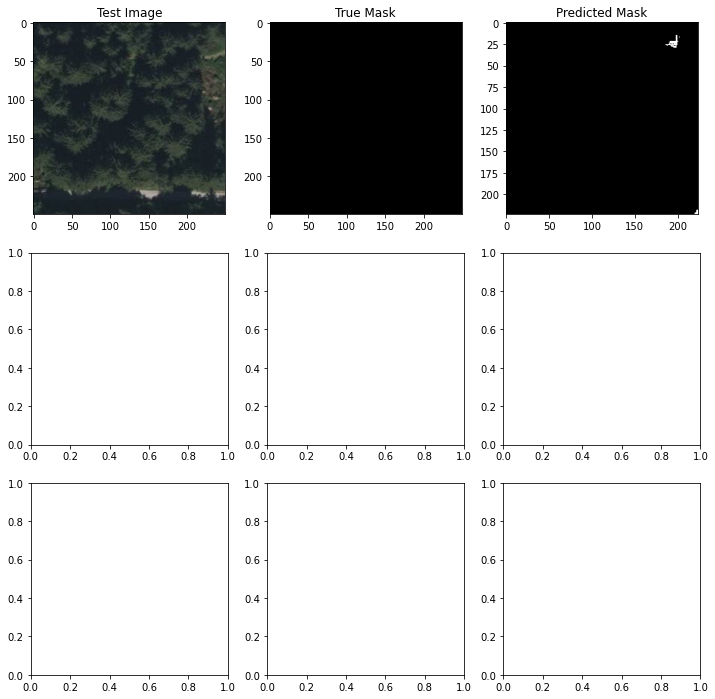

In [124]:
plot_comparison(X_true, y_true, y_pred[0])